In [2]:
import pandas as pd

path = "./archive/lemmetised_clean_data.csv"

# Charger uniquement les colonnes 'tags' et 'clean_text' du fichier CSV
df = pd.read_csv(path, usecols=['tags', 'clean_text'])

print(df.head())

                                                tags  \
0  ['Mental Health', 'Health', 'Psychology', 'Sci...   
1  ['Mental Health', 'Coronavirus', 'Science', 'P...   
2  ['Biotechnology', 'Neuroscience', 'Brain', 'We...   
3  ['Health', 'Neuroscience', 'Mental Health', 'P...   
4  ['Brain', 'Health', 'Development', 'Psychology...   

                                          clean_text  
0  photo josh riemer unsplash merry christmas hap...  
1  brain coronavirus guide curious troubling impa...  
2  mind nose smell training change brain six week...  
3  passionate synergy science technology provide ...  
4  youve heard havent phineas gage railroad worke...  


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

df_count = len(df)

# Supprime les valeurs manquantes dans la colonne 'clean_text'
df = df.dropna(subset=['clean_text'])

# Initialisation du TfidfVectorizer sans IDF et sans normalisation pour capturer les fréquences brutes
vectorizer = TfidfVectorizer(use_idf=False, norm=None)

# Transformation des textes en matrice TF
X_tfidf = vectorizer.fit_transform(df['clean_text'])

# Obtenir les mots du vocabulaire et leurs occurrences totales
vocab = vectorizer.get_feature_names_out()
word_frequencies = np.array(X_tfidf.sum(axis=0)).flatten()

# Créer un DataFrame avec les fréquences
word_freq_df = pd.DataFrame({'word': vocab, 'frequency': word_frequencies})

# Trier par ordre décroissant
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

print(word_freq_df)

                               word  frequency
707683                          one   476103.0
991870                         time   432366.0
576594                         like   373229.0
743813                       people   339329.0
599975                         make   306006.0
...                             ...        ...
586181           loggerinfostarting        1.0
586182            loggerinfosuccess        1.0
181583               corporationlet        1.0
586185                loggerinfourl        1.0
1111957  zzzzzzzzzzzzzzzzzzzzzzzzzz        1.0

[1111958 rows x 2 columns]


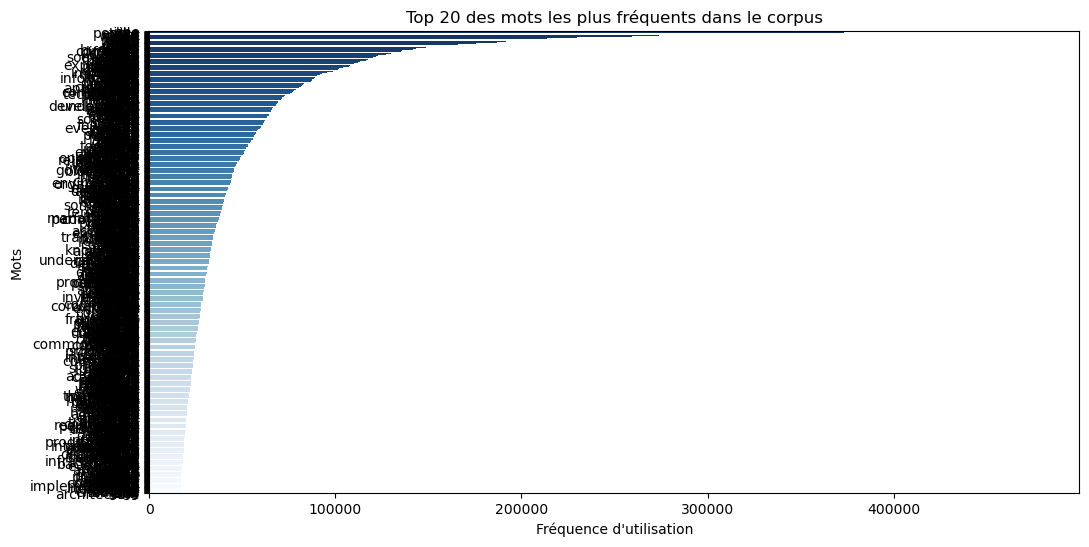

In [4]:
# 🔹 Tracer le graphique en barres
top_words = word_freq_df.head(1000)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_words['frequency'], y=top_words['word'], palette="Blues_r")

plt.xlabel("Fréquence d'utilisation")
plt.ylabel("Mots")
plt.title("Top 20 des mots les plus fréquents dans le corpus")
plt.show()

In [5]:
cumulative_freq = word_freq_df['frequency'].cumsum()
total_freq = cumulative_freq.iloc[-1]  # Fréquence totale de tous les mots

# Trouver le nombre de mots couvrant 95% du corpus
num_words_95 = (cumulative_freq <= total_freq * 0.95).sum()
num_words_99 = (cumulative_freq <= total_freq * 0.99).sum()

print(f"Nombre de mots nécessaires pour couvrir 95% du corpus : {num_words_95}")

print(f"Nombre de mots nécessaires pour couvrir 99% du corpus : {num_words_99}")


Nombre de mots nécessaires pour couvrir 95% du corpus : 28387
Nombre de mots nécessaires pour couvrir 99% du corpus : 350728


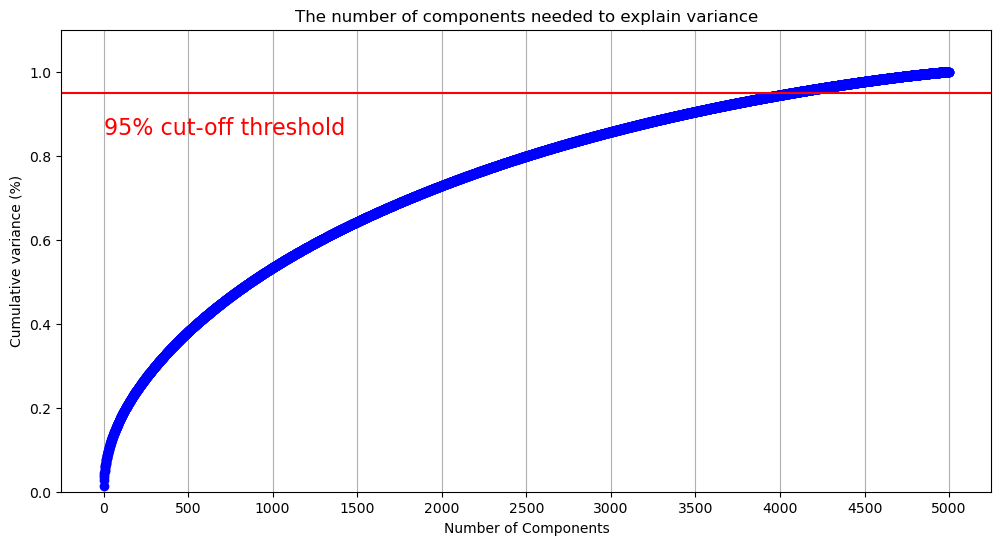

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler

# 2. Transformation du texte en matrice TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limiter le nombre de caractéristiques pour éviter la dimensionnalité élevée
X_tfidf = vectorizer.fit_transform(df['clean_text'])

# Scale the data to the range between 0 and 1
scaler = MaxAbsScaler()
data_rescaled = scaler.fit_transform(X_tfidf)

# Convertir la matrice sparse en matrice dense
data_rescaled_dense = data_rescaled.astype(np.float32).toarray()

# Appliquer PCA sur la matrice dense
pca = PCA()
pca.fit(data_rescaled_dense)


# Tracer la variance expliquée cumulée
plt.rcParams["figure.figsize"] = (12, 6)

fig, ax = plt.subplots()

# Créer xi en fonction du nombre réel de composants PCA
xi = np.arange(1, pca.n_components_ + 1)

# Cumul des variances expliquées
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)

# Tracer la courbe
plt.plot(xi, y, marker='o', linestyle='--', color='b')

# Ajouter la ligne seuil de 95%
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, "95% cut-off threshold", color='red', fontsize=16)

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, pca.n_components_ + 1, step=500))  # Ajuster le nombre de ticks pour correspondre au nombre de composants
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

ax.grid(axis='x')
plt.show()

# 6. Sauvegarder le DataFrame résultant dans un nouveau fichier CSV
# result_df.to_csv('./archive/pca_dataset.csv', index=False)

# Afficher un aperçu du nouveau DataFrame
# print(result_df.head())


In [7]:
# Calculer la variance expliquée par chaque composant
explained_variance = pca.explained_variance_ratio_

# Tracer la variance expliquée cumulée
cumulative_variance = explained_variance.cumsum()

# Trouver le nombre de composants qui expliquent 95% de la variance

optimal_components_95 = next(i for i, v in enumerate(cumulative_variance) if v >= 0.95)

print(f"Nombre de composants pour 95% de variance expliquée : {optimal_components_95 + 1}")

Nombre de composants pour 95% de variance expliquée : 4079


In [ ]:
# Appliquer PCA avec le nombre optimal de composants
pca_optimal = PCA(n_components=optimal_components_95 + 1)  # +1 car indexé à partir de 0
X_pca = pca_optimal.fit_transform(data_rescaled_dense)

# 3. Créer un DataFrame avec les résultats de PCA
# Nous allons combiner les 50 composants dans une seule colonne sous forme de vecteur
df['PCA_text'] = [list(x) for x in X_pca]

# 4. Sélectionner les colonnes 'tags', 'clean_text' et 'PCA_text'
result_df = df[['tags', 'clean_text', 'PCA_text']]

# Afficher un aperçu du nouveau DataFrame
print(result_df.head())

                                                tags  \
0  ['Mental Health', 'Health', 'Psychology', 'Sci...   
1  ['Mental Health', 'Coronavirus', 'Science', 'P...   
2  ['Biotechnology', 'Neuroscience', 'Brain', 'We...   
3  ['Health', 'Neuroscience', 'Mental Health', 'P...   
4  ['Brain', 'Health', 'Development', 'Psychology...   

                                          clean_text  \
0  photo josh riemer unsplash merry christmas hap...   
1  brain coronavirus guide curious troubling impa...   
2  mind nose smell training change brain six week...   
3  passionate synergy science technology provide ...   
4  youve heard havent phineas gage railroad worke...   

                                            PCA_text  
0  [-0.3379145, 0.15209268, -0.020482682, -0.0103...  
1  [0.0019770905, -0.056092292, -0.02170584, -0.1...  
2  [-0.0036328859, -0.037462097, 0.0056170523, -0...  
3  [0.16926497, -0.06898133, -0.07660041, -0.0197...  
4  [-0.054455258, 0.012808441, -0.08700939, 0.011..

In [9]:
# 5. Sauvegarder le DataFrame résultant dans un nouveau fichier CSV
result_df.to_csv('./archive/pca_data.csv', index=False)